<a href="https://colab.research.google.com/github/andersonsam/bc_heat_wave/blob/main/BC_heat_dome.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Preamble

Glaciated:  
BRIDGE RIVER (SOUTH BRANCH) BELOW BRIDGE GLACIER (08ME023)  
HOMATHKO RIVER AT THE MOUTH (08GD004)  
NORTH SASKATCHEWAN RIVER AT WHIRLPOOL POINT (05DA009)  

Snowy, then depleted:  
CHILLIWACK RIVER ABOVE SLESSE CREEK (08MH103)   
FINLAY RIVER ABOVE AKIE RIVER (07EA005)  
SKEENA RIVER AT USK (08EF001)  

Snowy, but already (or mostly) depleted:  
ELK RIVER AT FERNIE (08NK002)  
SALMO RIVER NEAR SALMO (08NE074)  
OYSTER RIVER BELOW WOODHUS CREEK (08HD011)  

Alberta -- Similar place, different response:  
ATHABASCA RIVER NEAR JASPER  
MIETTE RIVER NEAR JASPER  

Alberta -- Same river, different place:  
BOW RIVER AT LAKE LOUISE  
BOW RIVER AT BANFF  


In [1]:
dir_data = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/data' #where to store data
dir_data_realtime = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/data/temporary' #where to store data
!pip install geopandas

     |████████████████████████████████| 1.0 MB 4.3 MB/s 
     |████████████████████████████████| 6.3 MB 28.8 MB/s 
     |████████████████████████████████| 15.4 MB 83.8 MB/s 


In [2]:
#import required libraries

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import pickle

from datetime import datetime, date, timedelta
from google.colab import drive

In [3]:
#mount google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def plot_prov_ax(prov, ax):

  """
  plot borders of a province on a given axis

  prov: list of strings of provincial abbreviations; ['AB'], ['BC'], ['AB','BC'], etc; prov = 'all' will plot all provincial/territorial borders
  ax: axis on which to plot the provincial borders

  Examples:

  fig, ax = plt.subplots()
  plot_prov_ax(prov = ['BC', 'AB', 'SK'], ax = ax) #plots British Colubmia, Alberta, and Saskatchewan

  fig, ax = plt.subplots()
  plot_prov_ax(prov = 'all', ax = ax) #plots all provincial/territorial borders
  """

  #load shapefile of provincial boundaries
  provshapes_filename = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/data/PROVINCE.SHP'
  provshapes = gpd.read_file(provshapes_filename)

  #create list of all prov/territorial abbreviations
  prov_abbreviations = [
                        'AB',
                        'SK',
                        'MB',
                        'NL',
                        'PE',
                        'NS',
                        'NT',
                        'NU',
                        'ON',
                        'NB',
                        'YT',
                        'BC',
                        'QC'
                      ]

  #if wanting to plot all borders
  if prov == 'all':
    prov = prov_abbreviations

  #loop through each input province/territory and plot borders
  for pv in prov:

    #polygons of this province/territory
    prov_poly = provshapes['geometry'][prov_abbreviations.index(pv)]

    #some jurisdictions have multiple polygones from lakes/islands/etc (e.g. BC)
    if len(np.shape(prov_poly)) == 0: #if only one polygon to plot

      lonBorder,latBorder = prov_poly.exterior.coords.xy 
      ax.plot(lonBorder,latBorder,'k')

    else: #if multiply polygons in shape to plot

      for ind in range(len(prov_poly)): 
        lonBorder_segment,latBorder_segment = prov_poly[ind].exterior.coords.xy 
        ax.plot(lonBorder_segment,latBorder_segment,'k')

# Flow data

In [5]:
#load data

prov = ['BC','AB'] #for plotting -- plot_prov_ax(prov = prov, ax = ax)
flowpickle = ['BC_flowvars_1979_2015_missing_40_40_1.pickle', 'AB_flowvars_1979_2015_missing_40_40_1.pickle'] #filenames of .pickle files which contain AB/BC streamflow data

basinspickle = 'WSC_basins_1979_2015_missing_40_40_1.pickle'

#open flow data; since flow data is provided at provincial level, loop through/open/concatenate data from desired provinces
flowDicts = []
for flowfile in flowpickle:
  pickle_in = open(dir_data + '/' + flowfile,'rb')
  flowDicts.append(pickle.load(pickle_in))

#store flow data as a dictionary
flowDict = {
    'stationID' : np.hstack((flowDicts[0]['stationID'],flowDicts[1]['stationID'])), #station ID numbers
    'stationName' : np.hstack((flowDicts[0]['stationName'],flowDicts[1]['stationName'])), #station names
    'stationLat' : np.hstack((flowDicts[0]['stationLat'],flowDicts[1]['stationLat'])), #latitude of each station, in degrees
    'stationLon' : np.hstack((flowDicts[0]['stationLon'],flowDicts[1]['stationLon'])), #longitude of each station, in degrees
    'stationDrainageArea' : np.hstack((flowDicts[0]['stationDrainageArea'],flowDicts[1]['stationDrainageArea'])), #drainage area of each station
    'all_flowseason' : np.vstack((flowDicts[0]['all_flowseason'],flowDicts[1]['all_flowseason'])), #seasonal flow of each station, as evaluated across all years
    'all_flowseason_NF' : np.vstack((flowDicts[0]['all_flowseason_NF'],flowDicts[1]['all_flowseason_NF'])), #seasonal flow of each station, but with missing data filled with minimum value
    'all_flow' : np.vstack((flowDicts[0]['all_flow'],flowDicts[1]['all_flow'])), #daily flow data for each station
    'all_flow_NF' : np.vstack((flowDicts[0]['all_flow_NF'], flowDicts[1]['all_flow_NF'])), #daily flow data for each station, with missing data filled by seasonal value of the missing day
    'windowDates' : flowDicts[0]['windowDates'], #dates within window ("window" refers to time period of interest; here: 1979 - 2015)
    'windowYears' : flowDicts[0]['windowYears'], #years of each day within window
    'windowMonths' : flowDicts[0]['windowMonths'], #months of each day within window
    'windowDays' : flowDicts[0]['windowDays'], #day of month of each day within window
}

#unpack data
stationLat = flowDict['stationLat']
stationLon = flowDict['stationLon']
stationIDs_all = flowDict['stationID']
stationNames = flowDict['stationName']

flowDays = flowDict['windowDays']
flowMonths = flowDict['windowMonths']
flowYears = flowDict['windowYears']

F = flowDict['all_flow_NF'] 

#load basin data
pickle_in = open(dir_data + '/' + basinspickle, 'rb')
stationBasins = pickle.load(pickle_in)

In [6]:
stationIDs = [
              '08ME023',
              '08GD004',
              '05DA009',
              '08MH103',
              '07EA005',
              '08EF001',
              '08NK002',
              '08NE074',
              '08HD011'
]

stationInds = np.array([int(np.argwhere(stationIDs_all == stationID).squeeze()) for stationID in stationIDs])
classes = [0,0,0,1,1,1,2,2,2]

filenames = [stationID + '_QR_Oct-11-2021.csv' for stationID in stationIDs]

date_inds = np.argwhere(
    (flowMonths == 5) |
    (flowMonths == 6) |
    (flowMonths == 7) |
    (flowMonths == 8) |
    (flowMonths == 9)
).squeeze()

date_inds = np.argwhere(
    (flowMonths == 5) |
    (flowMonths == 6) |
    (flowMonths == 7) |
    (flowMonths == 8)
).squeeze()

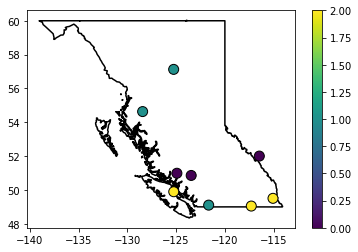

In [7]:
fig, ax = plt.subplots()
plot_prov_ax(prov = ['BC'], ax = ax)
s = ax.scatter(stationLon[stationInds], stationLat[stationInds], c = classes, zOrder = 5, s = 100, edgecolor = 'k', linewidth = 1)
plt.colorbar(s)

In [8]:
#calculate historical flows

Ndays = 153
Ndays = 123
Nstations = len(stationInds)

flow_mean = np.zeros((Nstations, Ndays))
flow_median = np.zeros((Nstations, Ndays))
flow_std = np.zeros((Nstations, Ndays))

for kk, station in enumerate(stationInds):

  flow_hist = F[station,:]
  flow_mat = flow_hist[date_inds].reshape(-1,Ndays)
  flow_mean[kk,:] = np.mean(flow_mat, axis = 0)
  flow_median[kk,:] = np.median(flow_mat, axis = 0)
  flow_std[kk,:] = np.std(flow_mat, axis = 0)

In [9]:
#calculate 2021 flows

flow_daily = np.zeros((Nstations, Ndays))

for station in range(Nstations):
  df = pd.read_csv(dir_data_realtime + '/' + filenames[station], header = 7)
  flow_realtime = df['Value (m3/s)']
  date_flow = [dd[:10] for dd in df[df.columns[0]]]
  datetimes = []
  for day in range(Ndays):
    datetimes.append(datetime(year = 2021, month = 5, day = 1) + timedelta(days = day))
    ds = str(datetime(year = 2021, month = 5, day = 1) + timedelta(days = day))[:10]
    inds = np.array([ii for ii, ee in enumerate(date_flow) if ee == ds])
    flow_daily[station,day] = np.nanmean(flow_realtime[inds])

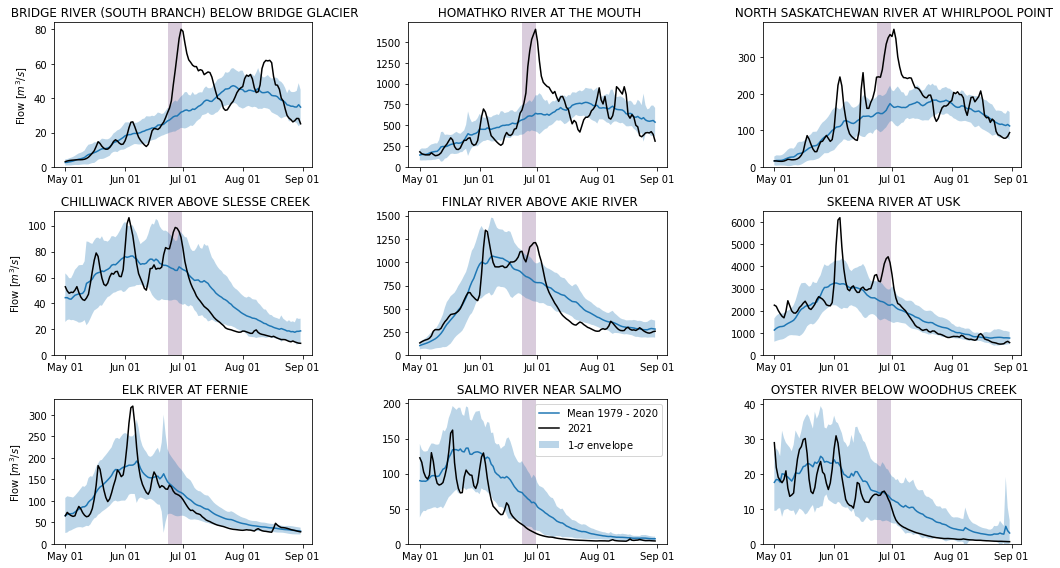

In [10]:
#visualize

saveIt = 0

heat_start = 55
heat_fin = heat_start+7
heat_start = datetime(year = 2021, month = 6, day = 23)
heat_fin = heat_start + timedelta(days = 7)
heat_shade = np.ones((1,1))

fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (15,8))

for station, ax in enumerate(axes.flatten()):

  y1 = flow_mean[station,:] + flow_std[station,:]
  y2 = flow_mean[station,:] - flow_std[station,:]

  bottom = 0
  top = np.max([flow_daily[station,:], y1])*1.05

  extent_heat = [mdates.date2num(heat_start), mdates.date2num(heat_fin), top, bottom]
  ax.imshow(heat_shade, extent = extent_heat, alpha = 0.2, aspect = 'auto', label = 'Heat wave')

  ax.fill_between(x = datetimes, y1 = y1, y2 = y2, alpha = 0.3, label = '1-$\sigma$ envelope')
  ax.plot(datetimes, flow_mean[station,:], label  = 'Mean 1979 - 2020')

  ax.plot(datetimes, flow_daily[station,:], 'k', label = '2021')

  ax.set_ylim(bottom = bottom, top = top)

  ax.set_xticks(ax.get_xticks()[::2])  
  monthFormatter = DateFormatter('%b %d')
  ax.xaxis.set_major_formatter(monthFormatter)
  ax.xaxis_date()

  if station % 3 == 0:
    ax.set_ylabel('Flow [$m^3/s$]')

  ax.set_title(stationNames[stationInds[station]])  
  if station == 7:
    ax.legend()

plt.tight_layout()

if saveIt:
  plt.savefig('heat_wave_flows.png', dpi = 300, bbox_inches = 'tight')

# Temp data

In [11]:
df = pd.read_csv(dir_data_realtime + '/stations_T2m_era.csv')
date_temp = df['date']

In [12]:
#calculate 2021 temp

temp_daily = np.zeros((Nstations, Ndays))

for station in range(Nstations):
  temp_realtime = df[stationIDs[station]]
  date_temp = [dd[:10] for dd in df[df.columns[1]]]
  datetimes = []
  for day in range(Ndays):
    datetimes.append(datetime(year = 2021, month = 5, day = 1) + timedelta(days = day))
    ds = str(datetime(year = 2021, month = 5, day = 1) + timedelta(days = day))[:10]
    inds = np.array([ii for ii, ee in enumerate(date_temp) if ee == ds])
    temp_daily[station,day] = np.nanmean(temp_realtime[inds])

In [13]:
len(df.columns[2:])

9

In [14]:
df = pd.read_csv(dir_data_realtime + '/stations_T2m_eraland.csv')
temp_date = df['date']
temp_months = np.array([int(dd[5:7]) for dd in temp_date])[:-212]
T = df[df.columns[2:]].values
T = T[:-121,:]

date_inds = np.argwhere(
    (temp_months == 5) |
    (temp_months == 6) |
    (temp_months == 7) |
    (temp_months == 8)
).squeeze()

In [15]:
#calculate historical flows

Ndays = 153
Ndays = 123
Nstations = len(stationInds)

temp_mean = np.zeros((Nstations, Ndays))
temp_median = np.zeros((Nstations, Ndays))
temp_std = np.zeros((Nstations, Ndays))

for kk, station in enumerate(stationInds):

  temp_hist = T[:,kk]
  temp_mat = temp_hist[date_inds].reshape(-1,Ndays)
  temp_mean[kk,:] = np.mean(temp_mat, axis = 0)
  temp_median[kk,:] = np.median(temp_mat, axis = 0)
  temp_std[kk,:] = np.std(temp_mat, axis = 0)

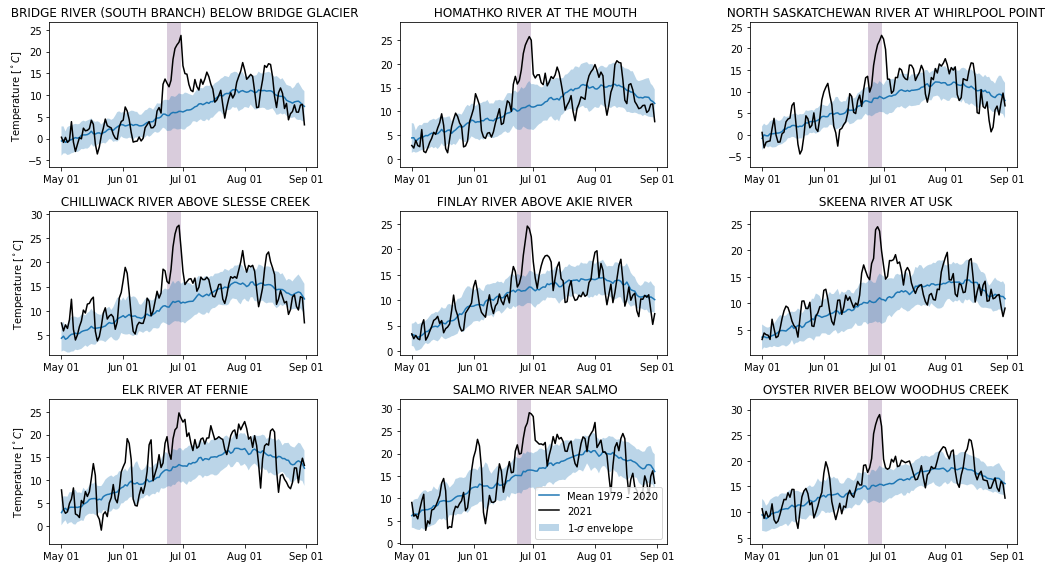

In [16]:
#visualize

saveIt = 1

heat_start = 55
heat_fin = heat_start+7
heat_start = datetime(year = 2021, month = 6, day = 23)
heat_fin = heat_start + timedelta(days = 7)
heat_shade = np.ones((1,1))

fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (15,8))

for station, ax in enumerate(axes.flatten()):

  y1 = temp_mean[station,:] + temp_std[station,:] - 273
  y2 = temp_mean[station,:] - temp_std[station,:] - 273

  bottom = np.min([temp_daily[station,:] - 273, y1]) - 3 
  top = np.max([temp_daily[station,:] - 273, y1]) + 3 

  extent_heat = [mdates.date2num(heat_start), mdates.date2num(heat_fin), top, bottom]
  ax.imshow(heat_shade, extent = extent_heat, alpha = 0.2, aspect = 'auto', label = 'Heat wave')

  ax.fill_between(x = datetimes, y1 = y1, y2 = y2, alpha = 0.3, label = '1-$\sigma$ envelope')
  ax.plot(datetimes, temp_mean[station,:] - 273, label  = 'Mean 1979 - 2020')

  ax.plot(datetimes, temp_daily[station,:] - 273, 'k', label = '2021')

  ax.set_ylim(bottom = bottom, top = top)

  ax.set_xticks(ax.get_xticks()[::2])  
  monthFormatter = DateFormatter('%b %d')
  ax.xaxis.set_major_formatter(monthFormatter)
  ax.xaxis_date()

  if station % 3 == 0:
    ax.set_ylabel('Temperature [$^\circ C$]')

  ax.set_title(stationNames[stationInds[station]])  
  if station == 7:
    ax.legend()

plt.tight_layout()

if saveIt:
  plt.savefig('heat_wave_temps.png', dpi = 300, bbox_inches = 'tight')

# Prep data

In [17]:
!pip install rasterio
import rasterio

     |████████████████████████████████| 19.3 MB 145 kB/s 


In [18]:
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, TimeDistributed, LSTM, Dense, Dropout, GlobalMaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

from shapely.geometry import Point, Polygon
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, KMeans

In [19]:
dir_models = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/models' #where to save trained models
dir_output = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/output' #where to save trained model outputs

In [167]:
#load data

prov = ['British Columbia', 'Alberta'] #for plotting -- plot_prov_ax(prov = prov, ax = ax)
prov = ['AB','BC']
flowpickle = ['BC_flowvars_1979_2015_missing_40_40_1.pickle', 'AB_flowvars_1979_2015_missing_40_40_1.pickle'] #filenames of .pickle files which contain AB/BC streamflow data
basinspickle = 'WSC_basins_1979_2015_missing_40_40_1.pickle' #filename of pickle file which contains the basin outlines

#open flow data; since flow data is provided at provincial level, loop through/open/concatenate data from desired provinces
flowDicts = []
for flowfile in flowpickle:
  pickle_in = open(dir_data + '/' + flowfile,'rb')
  flowDicts.append(pickle.load(pickle_in))

#store flow data as a dictionary
flowDict = {
    'stationID' : np.hstack((flowDicts[0]['stationID'],flowDicts[1]['stationID'])), #station ID numbers
    'stationName' : np.hstack((flowDicts[0]['stationName'],flowDicts[1]['stationName'])), #station names
    'stationLat' : np.hstack((flowDicts[0]['stationLat'],flowDicts[1]['stationLat'])), #latitude of each station, in degrees
    'stationLon' : np.hstack((flowDicts[0]['stationLon'],flowDicts[1]['stationLon'])), #longitude of each station, in degrees
    'stationDrainageArea' : np.hstack((flowDicts[0]['stationDrainageArea'],flowDicts[1]['stationDrainageArea'])), #drainage area of each station
    'all_flowseason' : np.vstack((flowDicts[0]['all_flowseason'],flowDicts[1]['all_flowseason'])), #seasonal flow of each station, as evaluated across all years
    'all_flowseason_NF' : np.vstack((flowDicts[0]['all_flowseason_NF'],flowDicts[1]['all_flowseason_NF'])), #seasonal flow of each station, but with missing data filled with minimum value
    'all_flow' : np.vstack((flowDicts[0]['all_flow'],flowDicts[1]['all_flow'])), #daily flow data for each station
    'all_flow_NF' : np.vstack((flowDicts[0]['all_flow_NF'], flowDicts[1]['all_flow_NF'])), #daily flow data for each station, with missing data filled by seasonal value of the missing day
    'windowDates' : flowDicts[0]['windowDates'], #dates within window ("window" refers to time period of interest; here: 1979 - 2015)
    'windowYears' : flowDicts[0]['windowYears'], #years of each day within window
    'windowMonths' : flowDicts[0]['windowMonths'], #months of each day within window
    'windowDays' : flowDicts[0]['windowDays'], #day of month of each day within window
}

#load daily temperature data
pickle_in = open(dir_data + '/' + 'tempDict_ERA5_1979_2015_075grid_AB_BC.pickle','rb')
tempDict = pickle.load(pickle_in)

#load daily precipitation data
pickle_in = open(dir_data + '/' + 'precDict_ERA5_1979_2015_075grid_AB_BC.pickle','rb')
precDict = pickle.load(pickle_in)

#unpack data
stationDrainageArea = np.array([np.double(area[1:]) for area in flowDict['stationDrainageArea']])
stationLat = flowDict['stationLat']
stationLon = flowDict['stationLon']
eraLat = tempDict['latERA']
eraLon = tempDict['lonERA']

flowDays = flowDict['windowDays']
flowMonths = flowDict['windowMonths']
flowYears = flowDict['windowYears']
eraDays = tempDict['daysERA']
eraMonths = tempDict['monthsERA']
eraYears = tempDict['yearsERA']

F = flowDict['all_flow_NF'] 
Tmax = np.asarray(tempDict['Tmax'])
Tmin = np.asarray(tempDict['Tmin'])
P = np.asarray(precDict['P'])

Tmean = np.mean(np.asarray(tempDict['T']), axis = 0) #mean annual temperature
Tmax_mean = np.mean(Tmax, axis = 0) #mean max temp
Tmin_mean = np.mean(Tmin, axis = 0) #mean min temp
Ptotal = np.sum(P, axis = 0) / int(len(P)/365) #total annual precip

#load basin data
pickle_in = open(dir_data + '/' + basinspickle, 'rb')
stationBasins = pickle.load(pickle_in)

In [168]:
#select subset of stations

maxLat = 56. #maximum station latitude to include
stationInds = np.squeeze(np.argwhere(np.expand_dims(stationLat,1)<maxLat)[:,0]) #indices of stations which are below maximum latitude
Nstations = len(stationInds)

F = np.asarray(F) #restructure F to be an array where rows are days and columns are stations
F = np.transpose(np.squeeze(F[stationInds]))

stationBasins = [stationBasins[ii] for ii in stationInds] #only use basins where stations are south of the maximum latitude
stationNames = flowDict['stationName'][stationInds]

In [169]:
#load DEM of region and characterize study basins

mosaic = rasterio.open(dir_data + '/AB_BC_mosaic.tif')
minlon, maxlat = mosaic.xy(0,0)
maxlon, minlat = mosaic.xy(15601,20401)
extentDEM = [minlon,maxlon,minlat,maxlat]
dem = mosaic.read(1)
dem = np.array(dem, dtype = np.float32)

minlon, maxlat = mosaic.xy(0,0)
maxlon, minlat = mosaic.xy(15601,20401)
extentDEM = [minlon,maxlon,minlat,maxlat]

stationGaugeElevation = dem[mosaic.index(x = stationLon[stationInds], y = stationLat[stationInds])] #calculate elevation (in m a.s.l.) of stream gauge

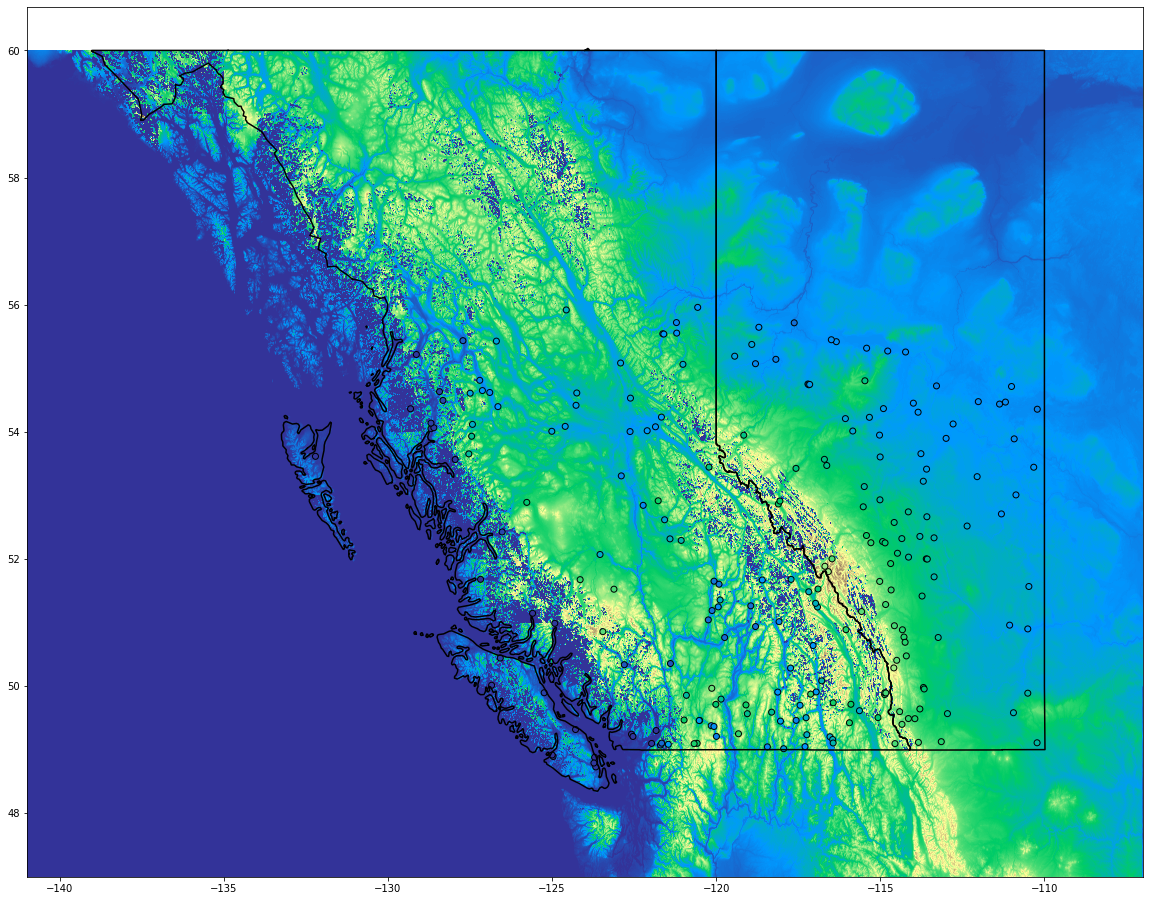

In [170]:
#visualize study region dem
fig, ax = plt.subplots(figsize = (20,16))
ax.imshow(dem, aspect = 'auto', vmin = 0, vmax = np.nanmax(dem), cmap = 'terrain', extent = extentDEM)
plot_prov_ax(prov = prov, ax = ax)
ax.scatter(stationLon[stationInds], stationLat[stationInds], c = stationGaugeElevation, edgecolor = 'k', cmap = 'terrain', vmin = 0, vmax = np.nanmax(dem))

In [171]:
print('Range of station elevation (in meters a.s.l.): ')
print('   Minimum: ', np.min(stationGaugeElevation))
print('   Maximum: ', np.max(stationGaugeElevation))
print('   Median:  ', np.median(stationGaugeElevation))

print('Range of station drainage area (in km^2): ')
print('   Minimum: ', np.min(stationDrainageArea))
print('   Maximum: ', np.max(stationDrainageArea))
print('   Median:  ', np.median(stationDrainageArea))

Range of station elevation (in meters a.s.l.): 
   Minimum:  8.0
   Maximum:  1706.0
   Median:   717.5
Range of station drainage area (in km^2): 
   Minimum:  6.22
   Maximum:  133000.0
   Median:   790.0


In [172]:
#reduce spatial extent to only bound the stations of interest

bounding_box = 1 #1/0: yes/no if you want to reduce the spatial extent
border = 1 #number of pixels to border the outermost stations

if bounding_box:

  #find max/min lat/lon of stations in set
  minLon = np.min(stationLon[stationInds])
  maxLon = np.max(stationLon[stationInds])
  minLat = np.min(stationLat[stationInds])
  maxLat = np.max(stationLat[stationInds])

  #find corresponding indices in ERA lat/lon 
  indMinLonERA = np.argmin(np.abs(eraLon - minLon))
  indMaxLonERA = np.argmin(np.abs(eraLon - maxLon))
  indMinLatERA = np.argmin(np.abs(eraLat - minLat))
  indMaxLatERA = np.argmin(np.abs(eraLat - maxLat))

  #pad the bounding box by the value specified by border, if there is room in ERA dataset
  if indMinLatERA + border > len(eraLat) - 1:
    indMinLatERA = len(eraLat) - 1
  else:
    indMinLatERA = indMinLatERA + border

  if indMaxLatERA - border < 1:
    indMaxLatERA = 0
  else:
    indMaxLatERA = indMaxLatERA - border + 1

  if indMaxLonERA + border > len(eraLon) - 1:
    indMaxLonERA = len(eraLon) - 1
  else:
    indMaxLonERA = indMaxLonERA + border

  if indMinLonERA - border < 1:
    indMinLonERA = 0
  else:
    indMinLonERA = indMinLonERA - border

  #trim temp/precip data to only those values within bounding box
  Tmax = Tmax[:, indMaxLatERA:indMinLatERA+1, indMinLonERA:indMaxLonERA+1]
  Tmin = Tmin[:, indMaxLatERA:indMinLatERA+1, indMinLonERA:indMaxLonERA+1]
  P = P[:, indMaxLatERA:indMinLatERA+1, indMinLonERA:indMaxLonERA+1]

  #spatial resolution in lat/lon dimensions
  d_eraLon = eraLon[1] - eraLon[0]
  d_eraLat = eraLat[0] - eraLat[1]

  #for visualization using plt.imshow -- define extent
  extentERA = [eraLon[indMinLonERA] - d_eraLon/2,eraLon[indMaxLonERA] + d_eraLon/2,eraLat[indMinLatERA] - d_eraLat/2,eraLat[indMaxLatERA] + d_eraLat/2]
  eraLon = eraLon[indMinLonERA:indMaxLonERA+1]
  eraLat = eraLat[indMaxLatERA:indMinLatERA+1]

In [173]:
#standardize data relative to training time period

#years/indices of testing/training
trainStartYear = 1979
trainFinYear = 2000
valStartYear = 2001
valFinYear = 2010
testStartYear = 2011
testFinYear = 2015

trainInds = np.squeeze(np.argwhere((flowYears>=trainStartYear) & (flowYears<=trainFinYear)))
valInds = np.squeeze(np.argwhere((flowYears>=valStartYear) & (flowYears<=valFinYear)))
testInds = np.squeeze(np.argwhere((flowYears>=testStartYear) & (flowYears<=testFinYear)))
Ntrain = len(trainInds)
Nval = len(valInds)
Ntest = len(testInds)

#standardize weather variables (normalize wrt training period), then reformat for memory
Tmaxmean_train = np.mean([Tmax[trainInds[ii]] for ii in range(len(trainInds))])
Tmaxstd_train = np.std([Tmax[trainInds[ii]] for ii in range(len(trainInds))])
Tmaxnorm = (Tmax - Tmaxmean_train)/Tmaxstd_train
Tmaxnorm = np.single(Tmaxnorm)

Tminmean_train = np.mean([Tmin[trainInds[ii]] for ii in range(len(trainInds))])
Tminstd_train = np.std([Tmin[trainInds[ii]] for ii in range(len(trainInds))])
Tminnorm = (Tmin - Tminmean_train)/Tminstd_train
Tminnorm = np.single(Tminnorm)

Pmean_train = np.mean([P[trainInds[ii]] for ii in range(len(trainInds))])
Pstd_train = np.std([P[trainInds[ii]] for ii in range(len(trainInds))])
Pnorm = (P - Pmean_train)/Pstd_train
Pnorm = np.single(Pnorm)

#normalize flow wrt to training period for each station
Fnorm = np.empty_like(F)
Fmean = np.zeros(len(stationInds))
Fstd = np.zeros(len(stationInds))
for station in range(np.shape(F)[1]):
  Fmean[station] = np.mean(F[trainInds,station])
  Fstd[station] = np.std(F[trainInds,station])
  Fnorm[:,station] = (F[:,station] - np.mean(F[trainInds,station]))/np.std(F[trainInds,station])

# Calculate % Glaciation

In [27]:
#open RGI data and extract area/locations

rgi_dir = dir_data + '/RGI/'

poly_filename = '02_rgi60_WesternCanadaUS.shp'
polys = gpd.read_file(rgi_dir + poly_filename)
cenLon = polys['CenLon']
cenLat = polys['CenLat']
area = polys['Area']

In [28]:
#for each basin, determine which glaciers are within its watershed boundaries

glacier_points = [Point(lon, lat) for lon, lat in zip(cenLon, cenLat)]
glacier_area_in = np.zeros(len(stationInds))
area_glaciers_in = np.zeros(len(stationInds))
glaciers_in_inds_all = [[] for kk in range(len(stationInds))]

for jj, basin in enumerate(stationBasins): #for each basin, determine which glaciers are within basin boundaries

  if basin is not None: #if basin outline exists (a few small non-glaciated basins do not have outlines)

    glaciers_in = np.zeros(len(cenLon)) #will be binary list of all glaciers: 1 == glacier in this basin, 0 == glacier not in this basin

    for kk, point in enumerate(glacier_points): #for each glacier, determine if within basin boundaries
        glaciers_in[kk] = basin.contains(point)

    glaciers_in_inds = np.squeeze(np.argwhere(glaciers_in))
    area_glaciers_in[jj] = np.sum(area[glaciers_in_inds]) #total area of glaciers which are within the watershed boundaries (in paper: A_glaciers)
    glaciers_in_inds_all[jj] = glaciers_in_inds

#calcualte percentage glaciation (in paper: G = A_glaciers / A_basin)
stationArea = np.array([float(flowDict['stationDrainageArea'][stationInds][kk][1:]) for kk in range(len(stationInds))]) #(in paper: A_basin)
stationPG = area_glaciers_in / stationArea #(in paper: G)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


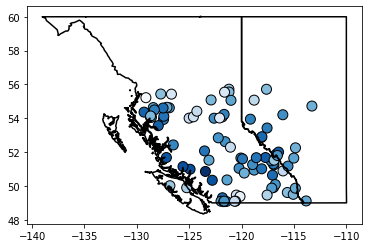

In [29]:
#visualize percentage glaciation in space

fig, ax = plt.subplots()
plot_prov_ax(prov, ax)
plt.scatter(stationLon[stationInds], stationLat[stationInds], c = np.log(stationPG), edgecolor = 'k', s = 100, cmap = 'Blues')

# Cluster seasonal flow

In [30]:
#create cluster input: half seasonal, quarter lat, quarter lon -- we want stations which have similar streamflow characteristics AND are nearby in space

frac_space = 0.5 #fraction of input vector to be the lat/lon
len_input = int(365/frac_space)
cluster_input = np.zeros((len(stationInds), len_input))

flowseason = flowDict['all_flowseason_NF'][stationInds,:]
stationLat_norm = (stationLat[stationInds] - np.mean(stationLat[stationInds])) / np.std(stationLat[stationInds])
stationLon_norm = (stationLon[stationInds] - np.mean(stationLon[stationInds])) / np.std(stationLon[stationInds])

for station in range(len(stationInds)):
  cluster_input[station,:365] = (flowseason[station,:] - np.mean(flowseason[station,:])) / np.std(flowseason[station,:]) #first half is normalized seasonal streamflow
  lat_inds = np.arange(365,365 + int((len_input - 365)/2)) #third quarter is normalized latitude
  lon_inds = np.arange(365 + int((len_input - 365)/2), len_input) #fourth quarter is normalized longitude
  cluster_input[station,lat_inds] = stationLat_norm[station] * np.ones_like(lat_inds)
  cluster_input[station,lon_inds] = stationLon_norm[station] * np.ones_like(lon_inds)

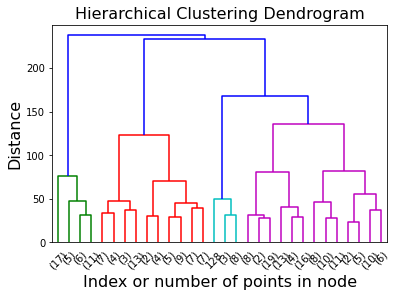

In [31]:
#visualize dendrogram to inform number of clusters

fig, ax = plt.subplots()
linked = linkage(cluster_input, 'ward')
dendrogram(linked, orientation = 'top', distance_sort = 'descending', truncate_mode = 'lastp', p = 30, ax = ax)

ax.set_xlabel("Index or number of points in node", fontsize = 16)
ax.set_ylabel('Distance', fontsize = 16)
ax.set_title('Hierarchical Clustering Dendrogram', fontsize = 16)

plt.show()

In [32]:
#from dendrogram, choose number of clusters and calculate mean pattern of each cluster

n_clusters_seasonal = 6
seasonal_clustering = AgglomerativeClustering(n_clusters = n_clusters_seasonal).fit(cluster_input)

#calculate average of each cluster
cluster_patterns = np.empty((n_clusters_seasonal, np.shape(cluster_input)[1]))
for cluster in range(n_clusters_seasonal):
  cluster_inds = np.argwhere(seasonal_clustering.labels_ == cluster)
  cluster_patterns[cluster,:] = np.mean(cluster_input[cluster_inds.reshape(-1,1),:], axis = 0)

In [33]:
#details for plotting/visualizations 

#determine RGB values of colormap to use: chosen from coolors.co
rgbs = [[241, 135, 1], #cluster 0
      [205, 223, 160], #cluster 1
      [159, 222, 249], #etc
      [233, 134, 207],
      [21, 96, 121],
      [100, 23, 35]]

rgbas = [[241, 135, 1,256],
      [205, 223, 160,256],
      [159, 222, 249,256],
      [233, 134, 207,256],
      [21, 96, 121,256],
      [100, 23, 35,256]]

rgbs_array = np.asarray(rgbs)/256
rgbas_array = np.asarray(rgbas)/256

#colours of each station
cStations = np.empty((len(stationInds), 3))
for kk in range(len(stationInds)):
  cStations[kk,:] = rgbs[seasonal_clustering.labels_[kk]]
cStations /= 256

#assign geographically relevant names for each cluster
cluster_names = [
                 'Central',       #cluster 0
                 'Southern',      #cluster 1
                 'Eastern',       #etc
                 'Coastal',
                 'North-Western',
                 'North-Eastern'
]

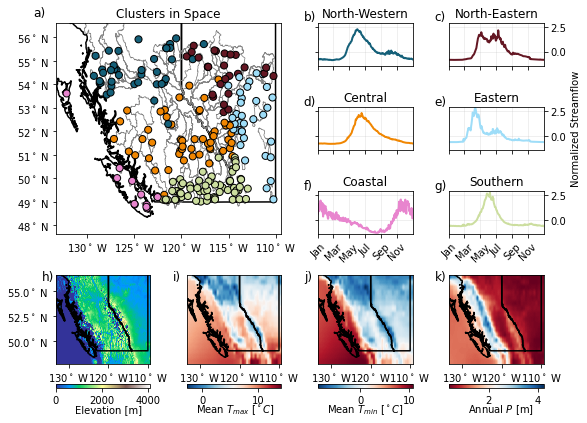

In [34]:
#visualize clustering results (spatial + temporal patterns), elevation, and climate

saveIt = 0

first_days_of_month = [0,31,59,90,120,151,181,212,243,273,304,334]
months_str = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fs = 12 #fontsize

abc = ['a)','b)','c)','d)','e)','f)','g)','h)','i)','j)','k)']

nrows = 5
ncols = 4

fig = plt.figure(figsize = (8,6))
gs = fig.add_gridspec(nrows = nrows, ncols = ncols)

##### top left side: spatial map of stations, coloured by cluster to which they belong

ax0 = fig.add_subplot(gs[:3,:2])

plot_prov_ax(prov=prov, ax = ax0)
ax0.scatter(stationLon[stationInds], stationLat[stationInds], c = cStations, s = 50, linewidth = 1, edgeColor = 'k', zOrder = 3)
ax0.tick_params(labelsize = fs-2)
ax0.set_title('Clusters in Space', fontsize = fs)
ax0.set_xlim((extentERA[0], extentERA[1]))
ax0.set_ylim((extentERA[2], extentERA[3]))
ax0.text(x = -0.1, y = 1.03, s = abc[0], transform = ax0.transAxes, fontsize = fs)

for basin in stationBasins:
  if basin is not None:
    x,y = basin.exterior.xy
    ax0.plot(x, y, color = 'gray', linewidth = 0.75)

##### top right side: subplots of seasonal streamflow of each cluster 

subplot_rows = [0,0,1,1,2,2]
subplot_cols = [2,3,2,3,2,3]

cluster_order = [4,5,0,2,3,1]

for kk, cluster in enumerate(cluster_order):

  ax = fig.add_subplot(gs[subplot_rows[kk], subplot_cols[kk]])
  ax.set_xticks(first_days_of_month[::2])
  ax.set_xlim((0,364))
  ax.set_ylim(bottom = np.min(cluster_patterns)-0.1, top = np.max(cluster_patterns)+0.1)
  ax.set_xticklabels(months_str[::2], rotation = 45)

  if kk<4:
    ax.set_xticklabels([])

  if np.mod(kk,2)==0:
    ax.set_yticklabels([])
  else:
    ax.tick_params(labelleft = False, labelright = True, left = False, right = True)

  if kk == 3:
    ax.set_ylabel('Normalized Streamflow')
    ax.yaxis.set_label_position("right")

  cluster_inds = np.squeeze(np.argwhere(seasonal_clustering.labels_ == cluster))

  var = cluster_patterns[cluster,:365]
  std = np.std(cluster_input[cluster_inds,:365], axis = 0)

  ax.plot(cluster_patterns[cluster,:365], color = rgbs_array[cluster], linewidth = 2)
  ax.tick_params(labelsize = fs-2)
  ax.set_title(cluster_names[cluster], fontsize = fs)
  ax.grid(True, alpha = 0.25)

  ax.text(x = -0.15, y = 1.05, s = abc[kk+1], transform = ax.transAxes, fontsize = fs)

##### bottom: elevation and climate subplots

ax_DEM = fig.add_subplot(gs[-2:,0])
ax_Tmax = fig.add_subplot(gs[-2:,1])
ax_Tmin = fig.add_subplot(gs[-2:,2])
ax_P = fig.add_subplot(gs[-2:,3])

#DEM subplot
extentDEM = [minlon, maxlon, minlat, maxlat]
im_DEM = ax_DEM.imshow(dem, vmin = 0, aspect = 'auto', cmap = 'terrain', extent = extentDEM)
ax_DEM.tick_params(right = False, left = True, labelright = False, labelleft = True)
cb = plt.colorbar(im_DEM, ax = ax_DEM, orientation = 'horizontal')
cb.ax.text(x = 0.2, y = -5, s = 'Elevation [m]', transform = cb.ax.transAxes)
ax_DEM.text(x = -0.15, y = 0.95, s = abc[7], transform = ax_DEM.transAxes, fontsize = fs)

#max temp subplot
im_Tmax = ax_Tmax.imshow(Tmax_mean - 273, aspect = 'auto', cmap = 'RdBu_r', extent = extentERA)
ax_Tmax.tick_params(right = False, left = False, labelright = False, labelleft = False)
cb = plt.colorbar(im_Tmax, ax = ax_Tmax, orientation = 'horizontal')
cb.ax.text(x = 0.1, y = -5, s = 'Mean $T_{max}$ [$^\circ C$]', transform = cb.ax.transAxes)
ax_Tmax.text(x = -0.15, y = 0.95, s = abc[8], transform = ax_Tmax.transAxes, fontsize = fs)

#min temp subplot
im_Tmin = ax_Tmin.imshow(Tmin_mean - 273, aspect = 'auto', cmap = 'RdBu_r', extent = extentERA)
ax_Tmin.tick_params(right = False, left = False, labelright = False, labelleft = False)
cb = plt.colorbar(im_Tmin, ax = ax_Tmin, orientation = 'horizontal')
cb.ax.text(x = 0.1, y = -5, s = 'Mean $T_{min}$ [$^\circ C$]', transform = cb.ax.transAxes)
ax_Tmin.text(x = -0.15, y = 0.95, s = abc[9], transform = ax_Tmin.transAxes, fontsize = fs)

#mean annual precip subplot
im_P = ax_P.imshow(Ptotal*6, aspect = 'auto', cmap = 'RdBu', extent = extentERA)
ax_P.tick_params(right = False, left = False, labelright = False, labelleft = False)
cb = plt.colorbar(im_P, ax = ax_P, orientation = 'horizontal')
cb.ax.text(x = 0.2, y = -5, s = 'Annual $P$ [m]', transform = cb.ax.transAxes)
ax_P.text(x = -0.15, y = 0.95, s = abc[10], transform = ax_P.transAxes, fontsize = fs)

#add provincial borders
plot_prov_ax(prov=prov, ax = ax_DEM)
plot_prov_ax(prov=prov, ax = ax_Tmax)
plot_prov_ax(prov=prov, ax = ax_Tmin)
plot_prov_ax(prov=prov, ax = ax_P)

#set extent
ax_DEM.set_xlim(left = extentERA[0], right = extentERA[1])
ax_DEM.set_ylim(bottom = extentERA[2], top = extentERA[3])
ax_Tmax.set_xlim(left = extentERA[0], right = extentERA[1])
ax_Tmax.set_ylim(bottom = extentERA[2], top = extentERA[3])
ax_Tmin.set_xlim(left = extentERA[0], right = extentERA[1])
ax_Tmin.set_ylim(bottom = extentERA[2], top = extentERA[3])
ax_P.set_xlim(left = extentERA[0], right = extentERA[1])
ax_P.set_ylim(bottom = extentERA[2], top = extentERA[3])

plt.tight_layout(h_pad = -0.5)

#edit ticklabels
axes = [ax0, ax_DEM, ax_Tmax, ax_Tmin, ax_P]
for ax in axes:
  xtls = [str(int(item.get_text()[1:])) + '$^\circ$ W' for item in ax.get_xticklabels()]
  ax.set_xticklabels(xtls)
  ytls = [item.get_text() + '$^\circ$ N' for item in ax.get_yticklabels()]
  ax.set_yticklabels(ytls)

if saveIt:
  plt.savefig('cluster_patterns_climate.png', bbox_inches = 'tight', dpi = 300)

plt.show()

In [35]:
#for each cluster, display elevation stats

for cluster in range(n_clusters_seasonal):

  inds = np.squeeze(np.argwhere(seasonal_clustering.labels_ == cluster))
  print(cluster_names[cluster])
  print('   Range of station elevation (in meters a.s.l.): ')
  print('     Minimum: ', np.min(stationGaugeElevation[inds]))
  print('     Maximum: ', np.max(stationGaugeElevation[inds]))
  print('     Mean:  ', np.mean(stationGaugeElevation[inds]))

Central
   Range of station elevation (in meters a.s.l.): 
     Minimum:  8.0
     Maximum:  1706.0
     Mean:   794.6923
Southern
   Range of station elevation (in meters a.s.l.): 
     Minimum:  38.0
     Maximum:  1660.0
     Mean:   930.9355
Eastern
   Range of station elevation (in meters a.s.l.): 
     Minimum:  523.0
     Maximum:  962.0
     Mean:   751.67645
Coastal
   Range of station elevation (in meters a.s.l.): 
     Minimum:  10.0
     Maximum:  87.0
     Mean:   36.25
North-Western
   Range of station elevation (in meters a.s.l.): 
     Minimum:  8.0
     Maximum:  917.0
     Mean:   520.6923
North-Eastern
   Range of station elevation (in meters a.s.l.): 
     Minimum:  494.0
     Maximum:  956.0
     Mean:   685.6667


In [36]:
#for each cluster, display area stats

for cluster in range(n_clusters_seasonal):

  inds = np.squeeze(np.argwhere(seasonal_clustering.labels_ == cluster))
  print(cluster_names[cluster])
  print('   Range of station drainage area (in km^2): ')
  print('     Minimum: ', np.min(stationDrainageArea[stationInds][inds]))
  print('     Maximum: ', np.max(stationDrainageArea[stationInds][inds]))
  print('     Median:  ', np.median(stationDrainageArea[stationInds][inds]))

Central
   Range of station drainage area (in km^2): 
     Minimum:  21.0
     Maximum:  55400.0
     Median:   1580.0
Southern
   Range of station drainage area (in km^2): 
     Minimum:  6.22
     Maximum:  11500.0
     Median:   288.5
Eastern
   Range of station drainage area (in km^2): 
     Minimum:  44.4
     Maximum:  4700.0
     Median:   579.5
Coastal
   Range of station drainage area (in km^2): 
     Minimum:  10.3
     Maximum:  480.0
     Median:   193.5
North-Western
   Range of station drainage area (in km^2): 
     Minimum:  13.2
     Maximum:  50300.0
     Median:   2850.0
North-Eastern
   Range of station drainage area (in km^2): 
     Minimum:  140.0
     Maximum:  74600.0
     Median:   1610.0


# Heat wave perturbations

In [233]:
#construct test predictor/target tensors -- here we won't make the train/validate predictor/target tensors to save memory; we will analyze the test period

#target data
y_train = np.squeeze([Fnorm[365:trainInds[-1]+1,ii] for ii in range(np.shape(F)[1])]).T #drop first 365 days since those are used to predict first flow day
y_val = np.squeeze([Fnorm[valInds,ii] for ii in range(np.shape(F)[1])]).T
y_test = np.squeeze([Fnorm[testInds,ii] for ii in range(np.shape(F)[1])]).T

y_train = y_train.astype(dtype = np.float16)
y_val = y_val.astype(dtype = np.float16)
y_test = y_test.astype(dtype = np.float16)

#predictor data
nchannels = 3 
x_test = np.empty((Ntest, 365,) + np.shape(Tmaxnorm)[1:] + (nchannels,),dtype=np.float16)

#first, make (n_time x n_lon x n_lat x n_channels) tensor -- will be used to form weather videos 
x_intermediate = np.empty(np.shape(Tmaxnorm) + (nchannels,),dtype='single')
x_intermediate[:,:,:,0] = Tmaxnorm
x_intermediate[:,:,:,1] = Tminnorm
x_intermediate[:,:,:,2] = Pnorm

Nyears = int(np.shape(x_intermediate)[0]/365)
leap_adjust = np.zeros(Nyears, dtype = 'int')
leap_adjust[np.mod(range(Nyears),4)==1] = 1
leap_adjust = np.cumsum(leap_adjust)
hot_days = np.array([np.arange(130,140)+365*kk + leap_adjust[kk] for kk in range(Nyears)]).reshape(-1,)
hot_anomaly_degrees = 10
Tmax_anomaly = hot_anomaly_degrees / Tmaxstd_train
Tmin_anomaly = hot_anomaly_degrees / Tminstd_train
perturb = np.zeros(np.shape(x_intermediate))
perturb[hot_days,:,:,0] = Tmax_anomaly
perturb[hot_days,:,:,1] = Tmin_anomaly

x_intermediate += perturb

#testing
for ii in range(Ntest):
  x_test[ii] = x_intermediate[ii + Ntrain + Nval - 365 : ii + Ntrain + Nval]
  # x_test[ii] = x_intermediate[-365 - Ntest + ii : -Ntest + ii]

#convert predict/target arrays to tensors
x_test = tf.convert_to_tensor(x_test)
y_test = tf.convert_to_tensor(y_test)

In [235]:
Nruns = 10

y_predict_perturb_all = np.zeros((Ntest, Nstations, Nruns))
y_predict_all = np.zeros((Ntest, Nstations, Nruns))

for run in range(Nruns):

  print('Run: ' + str(run))

  #load modelled (not perturbed)
  filename_test_fine = 'y_test_fine_predict_' + str(run) + '.csv'
  y_predict_all[:,:,run] = np.asarray(pd.read_csv(dir_output + '/' + filename_test_fine, header = None))

  for cluster in range(n_clusters_seasonal):

    print('\tCluster: ' + str(cluster))

    #prep model
    inds = np.argwhere(seasonal_clustering.labels_ == cluster).squeeze()
    filename_model = 'model_fine_' + str(run) + '_cluster_' + str(cluster) + '.h5'
    model = tf.keras.models.load_model(dir_models + '/' + filename_model)

    #predict perturbed (hot)
    y_predict_perturb_all[:,inds,run] = model.predict(x_test, batch_size = 64)

y_predict_perturb = np.mean(y_predict_perturb_all, axis = -1)
y_predict = np.mean(y_predict_all, axis = -1)

Run: 0
	Cluster: 0
	Cluster: 1
	Cluster: 2
	Cluster: 3
	Cluster: 4
	Cluster: 5
Run: 1
	Cluster: 0
	Cluster: 1
	Cluster: 2
	Cluster: 3
	Cluster: 4
	Cluster: 5
Run: 2
	Cluster: 0
	Cluster: 1
	Cluster: 2
	Cluster: 3
	Cluster: 4
	Cluster: 5
Run: 3
	Cluster: 0
	Cluster: 1
	Cluster: 2
	Cluster: 3
	Cluster: 4
	Cluster: 5
Run: 4
	Cluster: 0
	Cluster: 1
	Cluster: 2
	Cluster: 3
	Cluster: 4
	Cluster: 5
Run: 5
	Cluster: 0
	Cluster: 1
	Cluster: 2
	Cluster: 3
	Cluster: 4
	Cluster: 5
Run: 6
	Cluster: 0
	Cluster: 1
	Cluster: 2
	Cluster: 3
	Cluster: 4
	Cluster: 5
Run: 7
	Cluster: 0
	Cluster: 1
	Cluster: 2
	Cluster: 3
	Cluster: 4
	Cluster: 5
Run: 8
	Cluster: 0
	Cluster: 1
	Cluster: 2
	Cluster: 3
	Cluster: 4
	Cluster: 5
Run: 9
	Cluster: 0
	Cluster: 1
	Cluster: 2
	Cluster: 3
	Cluster: 4
	Cluster: 5


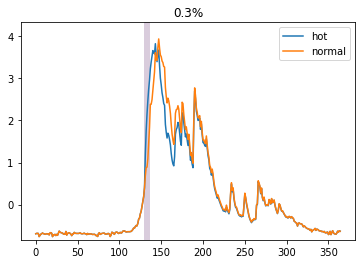

In [243]:
station = 4

fig, ax = plt.subplots()

x1 = y_predict_perturb[:365,station]
x2 = y_predict[:365,station]

top = np.max([x1,x2])*1.1
bottom = np.min([x1,x2])*1.1

extent_heat = [np.min(hot_days), np.min(hot_days)+7, bottom, top]
ax.imshow(heat_shade, extent = extent_heat, alpha = 0.2, aspect = 'auto', label = 'Heat wave')

ax.plot(x1, label = 'hot')
ax.plot(x2, label = 'normal')
ax.set_title(str(np.round(stationPG[station]*100, decimals = 1)) + '%')

ax.legend()




In [244]:
y_test_clusters = np.zeros((Ntest,n_clusters_seasonal))
y_test_perturb_clusters = np.zeros((Ntest,n_clusters_seasonal))

for cluster in range(n_clusters_seasonal):
  inds = np.argwhere(seasonal_clustering.labels_ == cluster).squeeze()
  y_test_clusters[:,cluster] = np.mean(y_predict[:,inds], axis = -1)
  y_test_perturb_clusters[:,cluster] = np.mean(y_predict_perturb[:,inds], axis = -1)

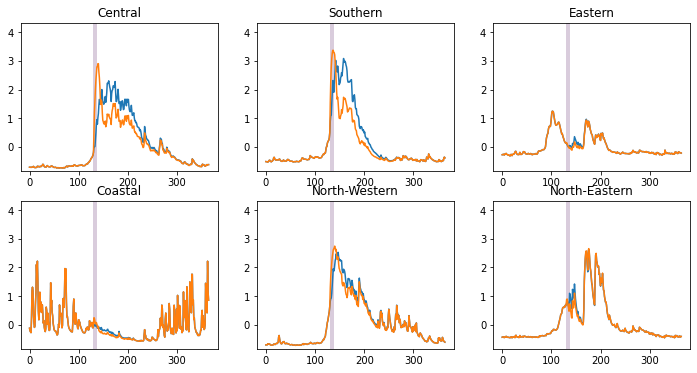

In [245]:
nrows = 2
ncols = 3

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4*ncols, 3*nrows))
for cluster, ax in enumerate(axes.flatten()):
  extent_heat = [np.min(hot_days), np.min(hot_days)+7, bottom, top]
  ax.imshow(heat_shade, extent = extent_heat, alpha = 0.2, aspect = 'auto', label = 'Heat wave')
  ax.plot(y_test_clusters[:365,cluster])
  ax.plot(y_test_perturb_clusters[:365,cluster])
  ax.set_title(cluster_names[cluster])


In [115]:
glacier_classes = 3*np.ones(Nstations)
glacier_classes[stationPG<=0.1] = 2
glacier_classes[stationPG<=0.01] = 1
glacier_classes[stationPG==0] = 0

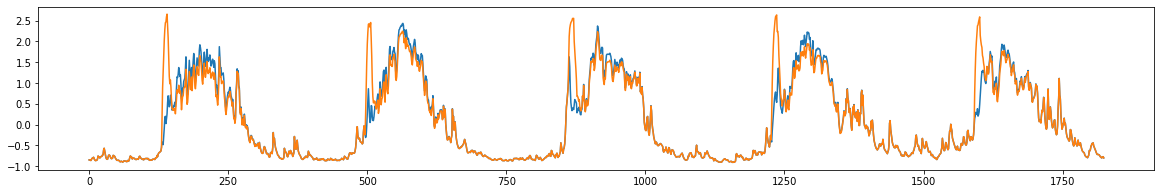

In [247]:
fig, ax = plt.subplots(figsize = (20,3))
glacier_class = 3
Ndays_plot = 5*365
x1 = np.mean(y_predict[:Ndays_plot,glacier_classes == glacier_class], axis = -1)
x2 = np.mean(y_predict_perturb[:Ndays_plot,glacier_classes == glacier_class], axis = -1)
ax.plot(x1)
ax.plot(x2)

Text(0.5, 1.0, 'Central')

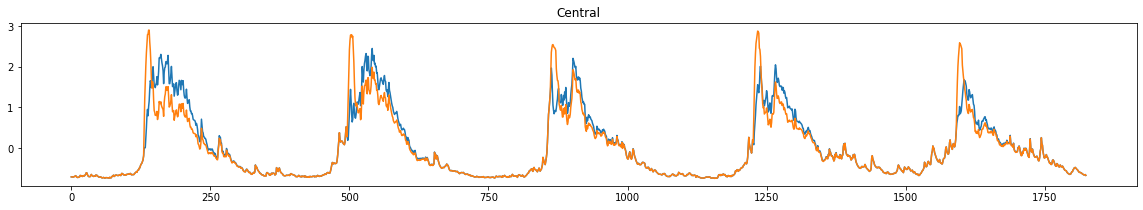

In [248]:
fig, ax = plt.subplots(figsize = (20,3))
cluster = 0
Ndays_plot = 5*365
x1 = np.mean(y_predict[:Ndays_plot, seasonal_clustering.labels_ == cluster], axis = -1)
x2 = np.mean(y_predict_perturb[:Ndays_plot, seasonal_clustering.labels_ == cluster], axis = -1)
ax.plot(x1)
ax.plot(x2)
ax.set_title(cluster_names[cluster])

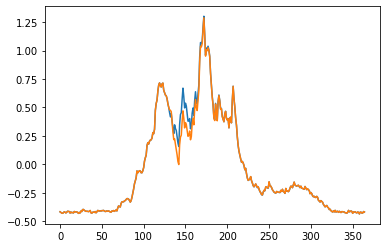

In [250]:
cluster = 5
Nyears_plot = 5
Ndays_plot = Nyears_plot*365
x1 = np.mean(y_predict[:Ndays_plot, seasonal_clustering.labels_ == cluster], axis = -1)
x2 = np.mean(y_predict_perturb[:Ndays_plot, seasonal_clustering.labels_ == cluster], axis = -1)

f1 = x1.reshape(Nyears_plot,-1).mean(axis = 0)
f2 = x2.reshape(Nyears_plot,-1).mean(axis = 0)
plt.plot(f1)
plt.plot(f2)

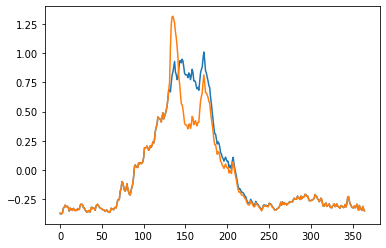

In [256]:
glacier_class = 0
Nyears_plot = 5
Ndays_plot = Nyears_plot*365
x1 = np.mean(y_predict[:Ndays_plot, glacier_classes == glacier_class], axis = -1)
x2 = np.mean(y_predict_perturb[:Ndays_plot, glacier_classes == glacier_class], axis = -1)

f1 = x1.reshape(Nyears_plot,-1).mean(axis = 0)
f2 = x2.reshape(Nyears_plot,-1).mean(axis = 0)
plt.plot(f1)
plt.plot(f2)

# Heat wave: rolling

In [ ]:
glacier_classes = 3*np.ones(Nstations)
glacier_classes[stationPG<=0.1] = 2
glacier_classes[stationPG<=0.01] = 1
glacier_classes[stationPG==0] = 0

In [50]:
#construct test predictor/target tensors -- here we won't make the train/validate predictor/target tensors to save memory; we will analyze the test period

#target data
y_train = np.squeeze([Fnorm[365:trainInds[-1]+1,ii] for ii in range(np.shape(F)[1])]).T #drop first 365 days since those are used to predict first flow day
y_val = np.squeeze([Fnorm[valInds,ii] for ii in range(np.shape(F)[1])]).T
y_test = np.squeeze([Fnorm[testInds,ii] for ii in range(np.shape(F)[1])]).T

y_train = y_train.astype(dtype = np.float16)
y_val = y_val.astype(dtype = np.float16)
y_test = y_test.astype(dtype = np.float16)

#first, make (n_time x n_lon x n_lat x n_channels) tensor -- will be used to form weather videos 
x_intermediate = np.empty(np.shape(Tmaxnorm) + (nchannels,),dtype='single')
x_intermediate[:,:,:,0] = Tmaxnorm
x_intermediate[:,:,:,1] = Tminnorm
x_intermediate[:,:,:,2] = Pnorm

In [143]:
#make perturbation
Nyears = int(np.shape(x_intermediate)[0]/365)
leap_adjust = np.zeros(Nyears, dtype = 'int')
leap_adjust[np.mod(range(Nyears),4)==1] = 1
leap_adjust = np.cumsum(leap_adjust)

days_start = np.arange(0,360,36)
heat_wave_duration = 7
days_fin = days_start + heat_wave_duration
N_heat_waves = len(days_start)

y_predict_heat_waves = np.zeros((Ntest,Nstations,N_heat_waves))

for kk, (day_start, day_fin) in enumerate(zip(days_start, days_fin)):

  print('Heat wave: ' + str(kk))

  hot_days = np.array([np.arange(day_start,day_fin)+365*kk + leap_adjust[kk] for kk in range(Nyears)]).reshape(-1,)
  hot_anomaly_degrees = 10
  Tmax_anomaly = hot_anomaly_degrees / Tmaxstd_train
  Tmin_anomaly = hot_anomaly_degrees / Tminstd_train
  perturb = np.zeros(np.shape(x_intermediate))
  perturb[hot_days,:,:,0] = Tmax_anomaly
  perturb[hot_days,:,:,1] = Tmin_anomaly

  x_intermediate_perturb = x_intermediate + perturb

  #predictor data
  nchannels = 3 
  x_test = np.empty((Ntest, 365,) + np.shape(Tmaxnorm)[1:] + (nchannels,),dtype=np.float16)
  for ii in range(Ntest):
    x_test[ii] = x_intermediate_perturb[ii + Ntrain + Nval - 365 : ii + Ntrain + Nval]

  #convert predict/target arrays to tensors
  x_test = tf.convert_to_tensor(x_test)
  y_test = tf.convert_to_tensor(y_test)

  Nruns = 10
  y_predict_perturb_all = np.zeros((Ntest, Nstations, Nruns))
  y_predict_all = np.zeros((Ntest, Nstations, Nruns))

  for run in range(Nruns):

    print('\tRun: ' + str(run))

    #load modelled (not perturbed)
    filename_test_fine = 'y_test_fine_predict_' + str(run) + '.csv'
    y_predict_all[:,:,run] = np.asarray(pd.read_csv(dir_output + '/' + filename_test_fine, header = None))

    for cluster in range(n_clusters_seasonal):

      print('\t\tCluster: ' + str(cluster))

      #prep model
      inds = np.argwhere(seasonal_clustering.labels_ == cluster).squeeze()
      filename_model = 'model_fine_' + str(run) + '_cluster_' + str(cluster) + '.h5'
      model = tf.keras.models.load_model(dir_models + '/' + filename_model)

      #predict perturbed (hot)
      y_predict_perturb_all[:365,inds,run] = model.predict(x_test[:365], batch_size = 64)

  y_predict_perturb = np.mean(y_predict_perturb_all, axis = -1)
  y_predict = np.mean(y_predict_all, axis = -1)

  y_predict_heat_waves[:365,:,kk] = y_predict_perturb[:365]

Heat wave: 0
	Run: 0
		Cluster: 0
		Cluster: 1
		Cluster: 2
		Cluster: 3
		Cluster: 4
		Cluster: 5
	Run: 1
		Cluster: 0
		Cluster: 1
		Cluster: 2
		Cluster: 3
		Cluster: 4
		Cluster: 5
	Run: 2
		Cluster: 0
		Cluster: 1
		Cluster: 2
		Cluster: 3
		Cluster: 4
		Cluster: 5
	Run: 3
		Cluster: 0
		Cluster: 1
		Cluster: 2
		Cluster: 3
		Cluster: 4
		Cluster: 5
	Run: 4
		Cluster: 0
		Cluster: 1
		Cluster: 2
		Cluster: 3
		Cluster: 4
		Cluster: 5
	Run: 5
		Cluster: 0
		Cluster: 1
		Cluster: 2
		Cluster: 3
		Cluster: 4
		Cluster: 5
	Run: 6
		Cluster: 0
		Cluster: 1
		Cluster: 2
		Cluster: 3
		Cluster: 4
		Cluster: 5
	Run: 7
		Cluster: 0
		Cluster: 1
		Cluster: 2
		Cluster: 3
		Cluster: 4
		Cluster: 5
	Run: 8
		Cluster: 0
		Cluster: 1
		Cluster: 2
		Cluster: 3
		Cluster: 4
		Cluster: 5
	Run: 9
		Cluster: 0
		Cluster: 1
		Cluster: 2
		Cluster: 3
		Cluster: 4
		Cluster: 5
Heat wave: 1
	Run: 0
		Cluster: 0
		Cluster: 1
		Cluster: 2
		Cluster: 3
		Cluster: 4
		Cluster: 5
	Run: 1
		Cluster: 0
		Clust

KeyboardInterrupt: ignored

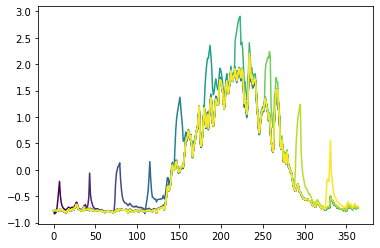

In [135]:
station = 71

norm = matplotlib.colors.Normalize(vmin = 0, vmax = N_heat_waves-1)
cmap = cm.get_cmap('viridis')

fig, ax = plt.subplots()

ax.plot(y_predict[:365,station], 'k')

for heat_wave in range(N_heat_waves):
  ax.plot(y_predict_heat_waves[:365,station,heat_wave], color = cmap(norm(heat_wave)))

In [136]:
max_diffs = np.max(y_predict_heat_waves - np.expand_dims(y_predict, axis = -1), axis = 0)
min_diffs = np.min(y_predict_heat_waves[:365,:,:] - np.expand_dims(y_predict[:365,:], axis = -1), axis = 0)


In [137]:
np.shape(max_diffs)

(226, 10)

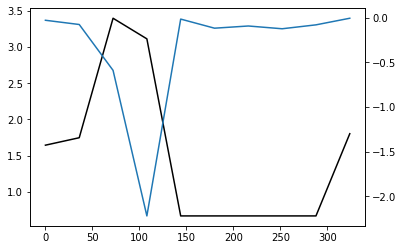

In [138]:
station = 2

fig, ax = plt.subplots()
ax.plot(days_start, max_diffs[station,:],'k')
ax2 = ax.twinx()
ax2.plot(days_start, min_diffs[station,:])


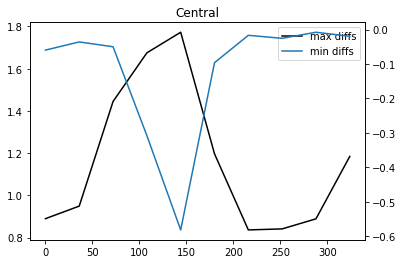

In [139]:
cluster = 0

inds = np.argwhere(seasonal_clustering.labels_ == cluster).squeeze()
x1 = np.mean(max_diffs[inds,:], axis = 0)
x2 = np.mean(min_diffs[inds,:], axis = 0)

fig, ax = plt.subplots()
ax.plot(days_start, x1,'k', label = 'max diffs')
ax2 = ax.twinx()
ax2.plot(days_start, x2, label = 'min diffs')

ax.set_title(cluster_names[cluster])

#one legend with labels from both ax and ax2
h, l = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
labels = l+l2
handles = h+h2
ax.legend(handles, labels)


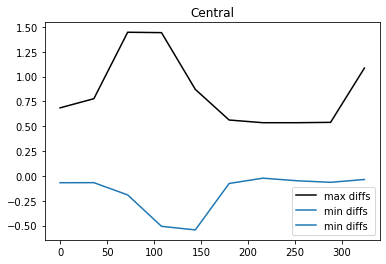

In [141]:
glacier_class = 0

inds = np.argwhere(glacier_classes == glacier_class).squeeze()
x1 = np.mean(max_diffs[inds,:], axis = 0)
x2 = np.mean(min_diffs[inds,:], axis = 0)

fig, ax = plt.subplots()
ax.plot(days_start, x1,'k', label = 'max diffs')
# ax2 = ax.twinx()
ax.plot(days_start, x2, label = 'min diffs')

ax.set_title(cluster_names[cluster])

#one legend with labels from both ax and ax2
h, l = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
labels = l+l2
handles = h+h2
ax.legend(handles, labels)


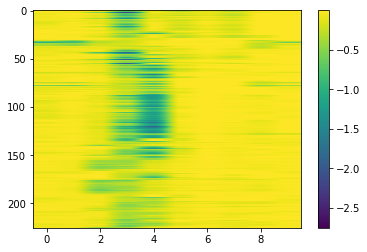

In [142]:
plt.imshow(min_diffs, aspect = 'auto')
plt.colorbar()

# Heat wave: from ERA5 data

In [209]:
#load data

#load daily temperature data
pickle_in = open(dir_data + '/' + 'tempDict_ERA5_2020_2021_075grid_AB_BC.pickle','rb')
tempDict = pickle.load(pickle_in)

#load daily precipitation data
pickle_in = open(dir_data + '/' + 'precDict_ERA5_2020_2021_075grid_AB_BC.pickle','rb')
precDict = pickle.load(pickle_in)

Tmax = np.asarray(tempDict['Tmax'])[:,0,:,:]
Tmin = np.asarray(tempDict['Tmin'])[:,0,:,:]
P = np.asarray(precDict['P'])[:,0,:,:]


In [210]:
#select subset of stations

maxLat = 56. #maximum station latitude to include

#reduce spatial extent to only bound the stations of interest

bounding_box = 1 #1/0: yes/no if you want to reduce the spatial extent
border = 1 #number of pixels to border the outermost stations

if bounding_box:

  #find max/min lat/lon of stations in set
  minLon = np.min(stationLon[stationInds])
  maxLon = np.max(stationLon[stationInds])
  minLat = np.min(stationLat[stationInds])
  maxLat = np.max(stationLat[stationInds])

  #find corresponding indices in ERA lat/lon 
  indMinLonERA = np.argmin(np.abs(eraLon - minLon))
  indMaxLonERA = np.argmin(np.abs(eraLon - maxLon))
  indMinLatERA = np.argmin(np.abs(eraLat - minLat))
  indMaxLatERA = np.argmin(np.abs(eraLat - maxLat))

  #pad the bounding box by the value specified by border, if there is room in ERA dataset
  if indMinLatERA + border > len(eraLat) - 1:
    indMinLatERA = len(eraLat) - 1
  else:
    indMinLatERA = indMinLatERA + border

  if indMaxLatERA - border < 1:
    indMaxLatERA = 0
  else:
    indMaxLatERA = indMaxLatERA - border + 1

  if indMaxLonERA + border > len(eraLon) - 1:
    indMaxLonERA = len(eraLon) - 1
  else:
    indMaxLonERA = indMaxLonERA + border

  if indMinLonERA - border < 1:
    indMinLonERA = 0
  else:
    indMinLonERA = indMinLonERA - border

  #trim temp/precip data to only those values within bounding box
  Tmax = Tmax[:, indMaxLatERA:indMinLatERA+1, indMinLonERA:indMaxLonERA+1]
  Tmin = Tmin[:, indMaxLatERA:indMinLatERA+1, indMinLonERA:indMaxLonERA+1]
  P = P[:, indMaxLatERA:indMinLatERA+1, indMinLonERA:indMaxLonERA+1]

  #spatial resolution in lat/lon dimensions
  d_eraLon = eraLon[1] - eraLon[0]
  d_eraLat = eraLat[0] - eraLat[1]

  #for visualization using plt.imshow -- define extent
  extentERA = [eraLon[indMinLonERA] - d_eraLon/2,eraLon[indMaxLonERA] + d_eraLon/2,eraLat[indMinLatERA] - d_eraLat/2,eraLat[indMaxLatERA] + d_eraLat/2]
  eraLon = eraLon[indMinLonERA:indMaxLonERA+1]
  eraLat = eraLat[indMaxLatERA:indMinLatERA+1]

In [211]:
#standardize data relative to training time period

#years/indices of testing/training

Nmodern = 578 - 365#len(Tmax) - 365

#standardize weather variables (normalize wrt training period), then reformat for memory
Tmaxnorm = (Tmax - Tmaxmean_train)/Tmaxstd_train
Tmaxnorm = np.single(Tmaxnorm)

Tminnorm = (Tmin - Tminmean_train)/Tminstd_train
Tminnorm = np.single(Tminnorm)

Pnorm = (P - Pmean_train)/Pstd_train
Pnorm = np.single(Pnorm)

In [157]:
#construct test predictor/target tensors -- here we won't make the train/validate predictor/target tensors to save memory; we will analyze the test period

#target data
y_train = np.squeeze([Fnorm[365:trainInds[-1]+1,ii] for ii in range(np.shape(F)[1])]).T #drop first 365 days since those are used to predict first flow day
y_val = np.squeeze([Fnorm[valInds,ii] for ii in range(np.shape(F)[1])]).T
y_test = np.squeeze([Fnorm[testInds,ii] for ii in range(np.shape(F)[1])]).T

y_train = y_train.astype(dtype = np.float16)
y_val = y_val.astype(dtype = np.float16)
y_test = y_test.astype(dtype = np.float16)

#predictor data
nchannels = 3 
x_modern = np.empty((Nmodern, 365,) + np.shape(Tmaxnorm)[1:] + (nchannels,),dtype=np.float16)

#first, make (n_time x n_lon x n_lat x n_channels) tensor -- will be used to form weather videos 
x_intermediate = np.empty(np.shape(Tmaxnorm) + (nchannels,),dtype='single')
x_intermediate[:,:,:,0] = Tmaxnorm
x_intermediate[:,:,:,1] = Tminnorm
x_intermediate[:,:,:,2] = Pnorm

#testing
for ii in range(Nmodern):
  x_modern[ii] = x_intermediate[ii: ii + 365]

#convert predict/target arrays to tensors
x_modern = tf.convert_to_tensor(x_modern)

In [158]:
Nruns = 10

y_predict_modern_all = np.zeros((Nmodern, Nstations, Nruns))

for run in range(Nruns):

  print('Run: ' + str(run))

  for cluster in range(n_clusters_seasonal):

    print('\tCluster: ' + str(cluster))

    #prep model
    inds = np.argwhere(seasonal_clustering.labels_ == cluster).squeeze()
    filename_model = 'model_fine_' + str(run) + '_cluster_' + str(cluster) + '.h5'
    model = tf.keras.models.load_model(dir_models + '/' + filename_model)

    #predict perturbed (hot)
    y_predict_modern_all[:,inds,run] = model.predict(x_modern, batch_size = 64)

y_predict_modern = np.mean(y_predict_modern_all, axis = -1)

Run: 0
	Cluster: 0
	Cluster: 1
	Cluster: 2
	Cluster: 3
	Cluster: 4
	Cluster: 5
Run: 1
	Cluster: 0
	Cluster: 1
	Cluster: 2
	Cluster: 3
	Cluster: 4
	Cluster: 5
Run: 2
	Cluster: 0
	Cluster: 1
	Cluster: 2
	Cluster: 3
	Cluster: 4
	Cluster: 5
Run: 3
	Cluster: 0
	Cluster: 1
	Cluster: 2
	Cluster: 3
	Cluster: 4
	Cluster: 5
Run: 4
	Cluster: 0
	Cluster: 1
	Cluster: 2
	Cluster: 3
	Cluster: 4
	Cluster: 5
Run: 5
	Cluster: 0
	Cluster: 1
	Cluster: 2
	Cluster: 3
	Cluster: 4
	Cluster: 5
Run: 6
	Cluster: 0
	Cluster: 1
	Cluster: 2
	Cluster: 3
	Cluster: 4
	Cluster: 5
Run: 7
	Cluster: 0
	Cluster: 1
	Cluster: 2
	Cluster: 3
	Cluster: 4
	Cluster: 5
Run: 8
	Cluster: 0
	Cluster: 1
	Cluster: 2
	Cluster: 3
	Cluster: 4
	Cluster: 5
Run: 9
	Cluster: 0
	Cluster: 1
	Cluster: 2
	Cluster: 3
	Cluster: 4
	Cluster: 5


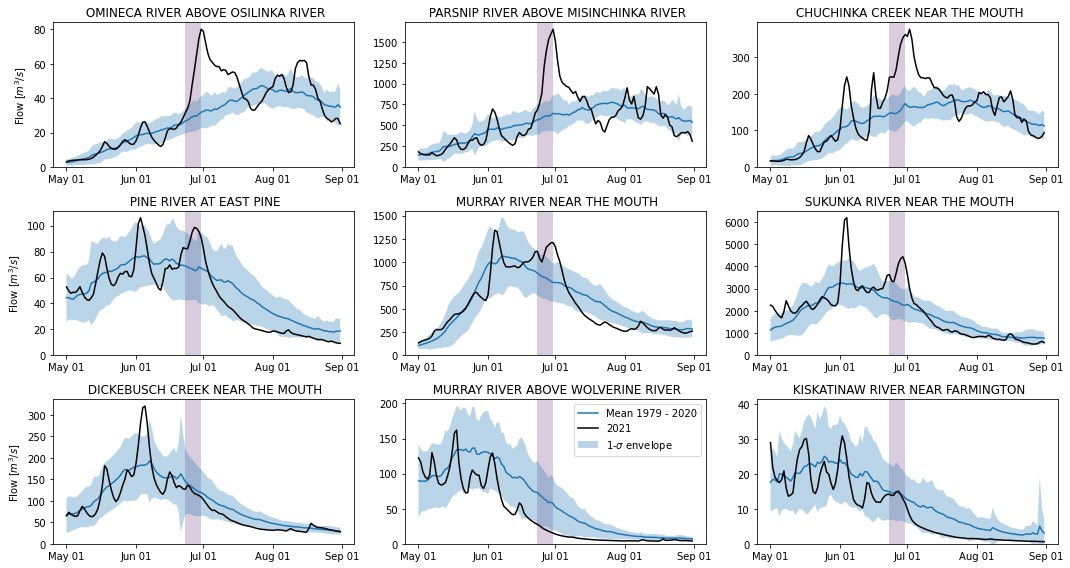

In [163]:
#visualize

saveIt = 0

heat_start = 55
heat_fin = heat_start+7
heat_start = datetime(year = 2021, month = 6, day = 23)
heat_fin = heat_start + timedelta(days = 7)
heat_shade = np.ones((1,1))

fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (15,8))

for station, ax in enumerate(axes.flatten()):

  y1 = flow_mean[station,:] + flow_std[station,:]
  y2 = flow_mean[station,:] - flow_std[station,:]

  bottom = 0
  top = np.max([flow_daily[station,:], y1])*1.05

  extent_heat = [mdates.date2num(heat_start), mdates.date2num(heat_fin), top, bottom]
  ax.imshow(heat_shade, extent = extent_heat, alpha = 0.2, aspect = 'auto', label = 'Heat wave')

  ax.fill_between(x = datetimes, y1 = y1, y2 = y2, alpha = 0.3, label = '1-$\sigma$ envelope')
  ax.plot(datetimes, flow_mean[station,:], label  = 'Mean 1979 - 2020')

  ax.plot(datetimes, flow_daily[station,:], 'k', label = '2021')

  ax.set_ylim(bottom = bottom, top = top)

  ax.set_xticks(ax.get_xticks()[::2])  
  monthFormatter = DateFormatter('%b %d')
  ax.xaxis.set_major_formatter(monthFormatter)
  ax.xaxis_date()

  if station % 3 == 0:
    ax.set_ylabel('Flow [$m^3/s$]')

  ax.set_title(stationNames[station])  
  if station == 7:
    ax.legend()

plt.tight_layout()

if saveIt:
  plt.savefig('heat_wave_flows.png', dpi = 300, bbox_inches = 'tight')

In [177]:
np.shape(Fmean)

(226,)

In [203]:
np.argwhere(stationIDs_all[stationInds] == stationIDs[8]).squeeze()

array(37)

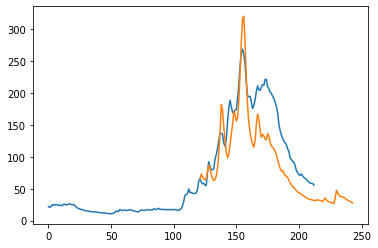

In [230]:
kk = 6
station = np.argwhere(stationIDs_all[stationInds] == stationIDs[kk]).squeeze()

y1 = y_predict_modern[:,station] * Fstd[station] + Fmean[station]
y2 = flow_daily[kk,:]

x1 = np.arange(len(y1))
x2 = np.arange(len(y2)) + 121

plt.plot(x1, y1)
plt.plot(x2, y2)


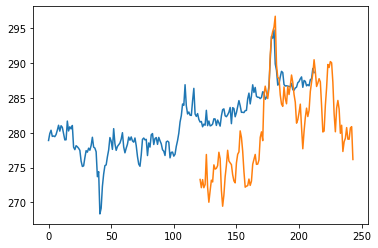

In [229]:
plt.plot(x1, Tmax[365:Nmodern+365,7,13])
plt.plot(x2, temp_daily[0,:])

In [226]:
eraLon[13], eraLat[7]

(-123.25, 51.0)

In [218]:
SI = np.array([int(np.argwhere(stationIDs_all == stationID).squeeze()) for stationID in stationIDs])
stationLon[SI[0]], stationLat[SI[1]]

(-123.4533, 50.98636)

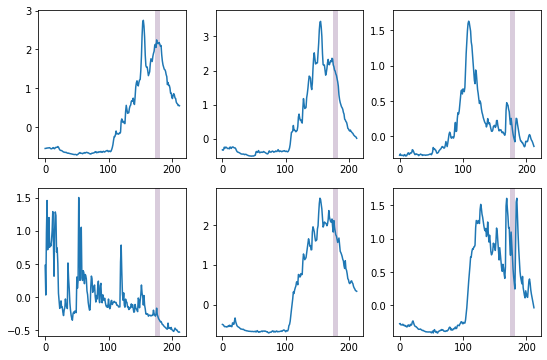

In [232]:
nrows = 2
ncols = 3
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (3*ncols, 3*nrows)) 
for cluster , ax in enumerate(axes.flatten()):
  
  inds = np.argwhere(seasonal_clustering.labels_ == cluster).squeeze()
  x1 = np.mean(y_predict_modern[:,inds], axis = -1)

  top = np.max(x1)*1.1
  bottom = np.min(x1)*1.1

  extent_heat = [174, 181, bottom, top]
  ax.imshow(heat_shade, extent = extent_heat, alpha = 0.2, aspect = 'auto', label = 'Heat wave')

  ax.plot(x1)


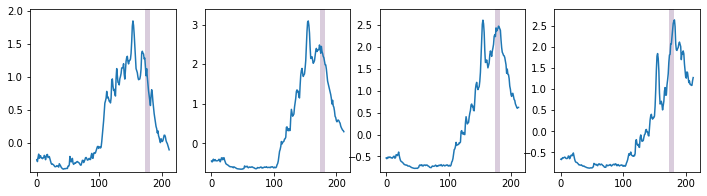

In [235]:
nrows = 1
ncols = 4
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (3*ncols, 3*nrows)) 
for glacier_class, ax in enumerate(axes.flatten()):
  
  inds = np.argwhere(glacier_classes == glacier_class).squeeze()
  x1 = np.mean(y_predict_modern[:,inds], axis = -1)

  top = np.max(x1)*1.1
  bottom = np.min(x1)*1.1

  extent_heat = [174, 181, bottom, top]
  ax.imshow(heat_shade, extent = extent_heat, alpha = 0.2, aspect = 'auto', label = 'Heat wave')

  ax.plot(x1)
